# Introduction: Random Forest in Python

In this notebook, we will implement a random forest in Python. With machine learning in Python, it's very easy to build a complex model without having any idea how it works. Therefore, we'll start with a single decision tree and a simple problem, and then work our way to a random forest and a real-world problem. 

Once we understand how a single decision tree thinks, we can transfer this knowledge to an entire forest of trees.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set random seed to ensure reproducible runs
RSEED = 50

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz



DecisionTreeClassifier(random_state=50)

A decision tree is an intuitive model: it makes decisions much as we might when faced with a problem by constructing a flowchart of questions. For each of the nodes (except the leaf nodes), the five rows represent:

1. Question asked about the data based on a feature: this determines the way we traverse down the tree for a new datapoint.
2. `gini`: the Gini Impurity of the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
3. `samples`: number of training observations in the node
4. `value`: [number of samples in the first class, number of samples in the second class]
5. `class`: the class predicted for all the points in the node if the tree ended at this depth (defaults to 0 for a tie).

The leaf nodes (the terminal nodes at each branch) do not have a question because they are where the tree makes a prediction. All of the samples in a leaf node are assigned the same class. 

### Gini Impurity

The Gini Impurity represents the probability that a randomly selected sample from the node will be incorrectly classified according to the distribution of samples in the node. At the top, there is a 44.4% chance that a randomly selected point would be incorrectly classified. The Gini Impurity is how the decision tree makes splits. It splits the samples based on the value of a feature that reduces the Gini Impurity by the largest amount. 
If we do the math, the average (weighted by number of samples) Gini Impurity decreases as we move down the tree. 

Eventually, the average Gini Impurity goes to 0.0 as we correctly classify each point. However, correctly classifying every single training point is usually not a good indicator because that means the model will not be able to generalize to the testing data! This model correclty classifies every single training point because we did not limit the maximum depth and during training, we give the model the answers as well as the features.

### Limit Maximum Depth

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

# Real Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training. 

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem.

## Data Cleaning 

We'll read the data in and do a little cleaning. 

#syntax for getting sample from file
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

In [ ]:
#file 2015.csv has 441457 rows we take only 100000 rows
df = pd.read_csv('2015.csv').sample(100000,replace=True, random_state = RSEED)
df.head()


_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
1712     1.0     4.0  b'04132015'  b'04'  b'13'  b'2015'    1200.0   
1504     1.0     5.0  b'05042015'  b'05'  b'04'  b'2015'    1100.0   
1931     1.0     5.0  b'05052015'  b'05'  b'05'  b'2015'    1200.0   
2157     1.0     4.0  b'04122015'  b'04'  b'12'  b'2015'    1100.0   
2014     1.0     5.0  b'05042015'  b'05'  b'04'  b'2015'    1100.0   

             SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  _LMTACT1  \
1712  2.015002e+09  2.015002e+09       1.0  ...      9.0       9.0       9.0   
1504  2.015002e+09  2.015002e+09       1.0  ...      1.0       1.0       1.0   
1931  2.015002e+09  2.015002e+09       1.0  ...      4.0       2.0       3.0   
2157  2.015002e+09  2.015002e+09       1.0  ...      4.0       2.0       1.0   
2014  2.015002e+09  2.015002e+09       1.0  ...      4.0       2.0       1.0   

      _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  _AIDTST3  
1712       9.0       9.0       9.0       9.0       NaN       NaN       NaN  
1504       1.0       1.0       1.0       1.0       NaN       NaN       1.0  
1931       3.0       4.0       1.0       1.0       NaN       NaN       2.0  
2157       1.0       1.0       1.0       1.0       1.0       9.0       2.0  
2014       1.0       1.0       1.0       1.0       NaN       NaN       2.0  

[5 rows x 330 columns]

In [ ]:
df.dtypes

_STATE      float64
FMONTH      float64
IDATE        object
IMONTH       object
IDAY         object
             ...   
_RFSEAT2    float64
_RFSEAT3    float64
_FLSHOT6    float64
_PNEUMO2    float64
_AIDTST3    float64
Length: 330, dtype: object

# syntax to select dataframe coulmns  with only numbers

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html



In [ ]:
#get columns with number only
df = df.select_dtypes('number')
df.info()
#seven columns are removed as their data types is not number

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1712 to 1197
Columns: 323 entries, _STATE to _AIDTST3
dtypes: float64(323)
memory usage: 247.2 MB


### Label Distribution

In [ ]:
# _RFHLTH IS FOR Adults with good health we will use this column as target or label
#column _RFHLTH is for good health with values  1=good health, 2=fair health,9=dont know

dRFHLTH=df['_RFHLTH']
print(df['_RFHLTH'])

1712    1.0
1504    1.0
1931    1.0
2157    9.0
2014    1.0
       ... 
204     2.0
1611    1.0
1089    1.0
2191    2.0
1197    2.0
Name: _RFHLTH, Length: 100000, dtype: float64


In [ ]:
# we will make _RFHLTH column as LABEL
#column _RFHLTH is for good health with values  1=good health, 2=fair health,9=dont know

# replace 2 with 0  in column _RFHLTH
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})

# select rows with 0 and 1 in column _RFHLTH
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

#rename _RFHLTH  Column as Label
df = df.rename(columns = {'_RFHLTH': 'label'})

#count Values in label column
df['label'].value_counts()

1.0    70529
0.0    28853
Name: label, dtype: int64

The label imbalanced means that accuracy is not the best metric. 

We won't do any data exploration in this notebook, but in general, exploring the data is a best practice. This can help you for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels).

In [ ]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99382 entries, 1712 to 1197
Columns: 314 entries, _STATE to _AIDTST3
dtypes: float64(314)
memory usage: 238.8 MB


In [ ]:
#drop columns with nan values
df=df.dropna(axis='columns')
df.shape

(99382, 97)

## Split Data into Training and Testing Set

To assess our predictions, we'll need to use a training and a testing set. The model learns from the training data and then makes predictions on the testing data. Since we have the correct answers for the testing data, we can tell how well the model is able to generalize to new data. It's important to only use the testing set once, because this is meant to be an estimate of how well the model will perform on new data. 

We'll save 30% of the examples for testing. 

In [ ]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [ ]:
train.shape

(69567, 96)

In [ ]:
test.shape

(29815, 96)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [ ]:
features = list(train.columns)
#following two fillna are not working as rows are large 69803,29916 hence for loop used
#train = train.fillna(train.mean(),inplace=True)
#test = test.fillna(test.mean(),inplace=True)
#for i in train.columns[train.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
#    train[i].fillna(train[i].mean(),inplace=True)

#for i in test.columns[test.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
#   test[i].fillna(test[i].mean(),inplace=True)

# Features for feature importances


In [ ]:
train.shape

(69567, 96)

In [ ]:
test.shape

(29815, 96)

In [ ]:
#check nan in train
check_nan_in_df = train.isnull().values.any()
print (check_nan_in_df)


False


In [ ]:
#check nan in test
check_nan_in_df = test.isnull().values.any()
print (check_nan_in_df)


False


In [ ]:
print(type(train_labels))

<class 'numpy.ndarray'>


In [ ]:
#train_labels is array 
array_has_nan = np.isnan(train_labels).any()
print(array_has_nan)

#check_nan_in_df = train_labels.isnull().values.any()
#print (check_nan_in_df)


False


In [ ]:
array_has_nan = np.isnan(test_labels).any()
print(array_has_nan)

#check_nan_in_df = train_labels.isnull().values.any()
#print (check_nan_in_df)


False


## Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting! 

In [ ]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1057 nodes with maximum depth 26.


## Assess Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba


https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict

In [ ]:
# Make probability predictions
#tree.predict_proba uses tree to predict classes for given input .output is two columns olumn0=0 class column1 =1class
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [ ]:
print(train_probs)

[0. 0. 0. ... 1. 1. 0.]


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 1.0


In [ ]:
#syntax to create list length=test_labels filled with 1's.here _ is variable in for loop
d=[1 for _ in range(len(test_labels))]
print(d)
print(type(d))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top. 

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [ ]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 21159, 0.0: 8656})
Counter({1.0: 21159, 0.0: 8656})


Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.71 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


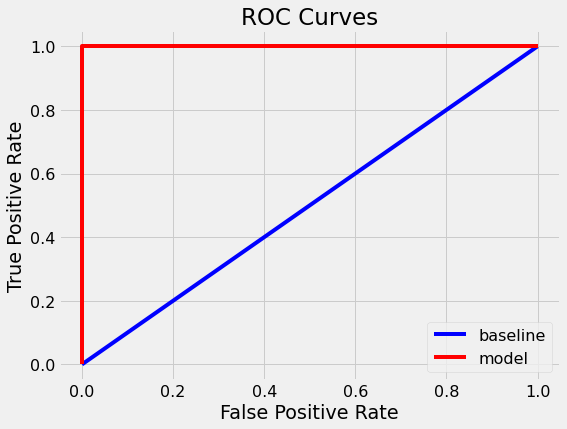

In [ ]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__. 

Another method to inspect the performance of a classification model is by making a confusion matrix.

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 8656     0]
 [    0 21159]]


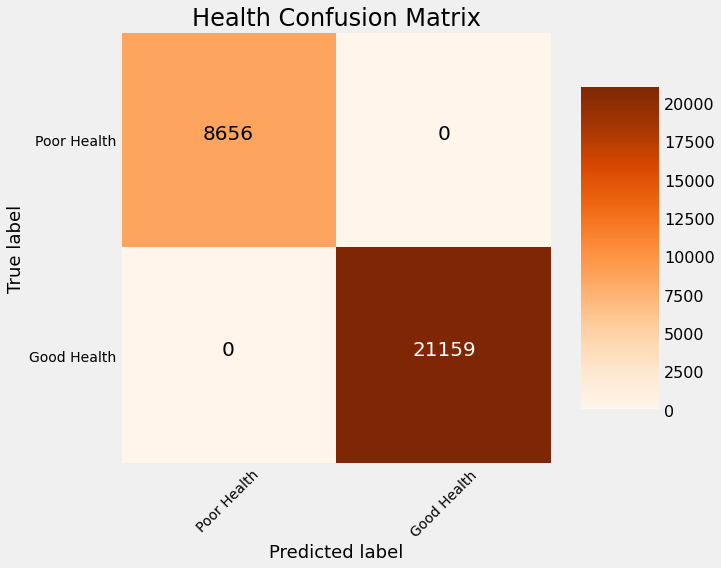

In [ ]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health). 

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [ ]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

feature  importance
34   EMPLOY1    0.147403
44   _LLCPWT    0.047806
23  CHCCOPD1    0.042605
15   BPHIGH4    0.038545
39    _STSTR    0.035356

We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature. 

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image. 

In [ ]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

from subprocess import call
# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

from IPython.display import Image

# Visualize
Image(filename='tree_real_data.png')

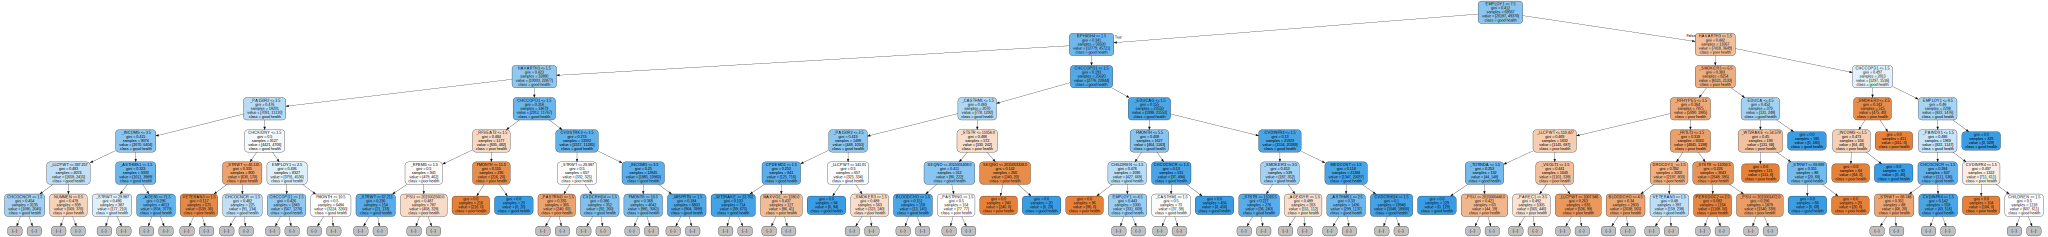

In [ ]:
from graphviz import Source
Source.from_file("tree_real_data.dot")


We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play. 

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

# Conclusions

In this notebook, we built and used a random forest machine learning model in Python. Rather than just writing the code and not understanding the model, we formed an understanding of the random forest by inspecting an individual decision tree and discussion its limitations. We visualized the decision tree to see how it makes decisions and also saw how one decision tree overfits to the trainig data. __To overcome the limitations of a single decision tree, we can train hundreds or thousands of them in a single ensemble model. This model, known as a random forest, trains each tree on a different set of the training observations, and make splits at each node based on a subset of the features leading to a model with reduced variance and better generalization performance on the testing set.__

A few key concepts to take away are

1. Individual decision tree: intuitive model that makes decisions based on a flowchart of questions asked about feature values. Has high variance indicated by overfitting to the training data.
2. Gini Impurity: Measure that the decision tree tries to minimize when splitting each node. Represents the probability that a randomly selected sample from a node will be incorreclty classified according to the distribution of samples in the node.
3. Bootstrapping: sampling random sets of observations with replacement. Method used by the random forest for training each decision tree.
4. Random subsets of features: selecting a random set of the features when considering how to split each node in a decision tree.
5. Random Forest: ensemble model made of hundreds or thousands of decision trees using bootstrapping, random subsets of features, and average voting to make predictions. 
6. Bias-variance tradeoff: the fundamental issue in machine learning that describes the tradeoff between a model with high complexity that learns the training data very well  at the cost of not being able to generalize to the testing data (high variance), and a simple model (high bias) that cannot even learn the training data. A random forest reduces the variance of a single decision tree while also accurately learning the training data leading to better predictions on the testing data.

Hopefully this notebook has given you not only the code required to use a random forest, but also the background necessary to understand how the model is making decisions. Machine learning is a powerful tool and it's important to not only know how to use the tool, but also to understand how it works!